# Diamonds Prices

About Dataset:

This Dataset contains approximately 53,940 diamonds with prices and 10 attributes (carat, cut, color, clarity, depth, table, price, x, y, and z). Most variables are numeric in nature, but the variables cut, color, and clarity are ordered factor variables with the following levels.

- price : price in US dollars ($326--$18,823)
- carat : weight of the diamond (0.2--5.01)
- cut   : quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color : diamond colour, from J (worst) to D (best)
- clarity : a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- x : length in mm (0--10.74)
- y : width in mm (0--58.9)
- z : depth in mm (0--31.8)
- depth : total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table : width of top of diamond relative to widest point (43--95)

In [38]:
# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,  AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import joblib
import warnings; warnings.filterwarnings("ignore")

In [39]:
df = pd.read_csv('/content/diamonds.csv')

In [40]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [41]:
# Drop any unnamed or index column automatically
df = df.loc[:, ~df.columns.astype(str).str.contains('Unnamed')]

In [42]:
# Verify
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [43]:
df.columns.tolist()

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']

In [44]:
# Dataset shape
df.shape

(53940, 10)

In [45]:
df.dtypes

,0
carat,float64
cut,object
color,object
clarity,object
depth,float64
table,float64
price,int64
x,float64
y,float64
z,float64


In [46]:
# Checking for null values
df.isnull().sum()

,0
carat,0
cut,0
color,0
clarity,0
depth,0
table,0
price,0
x,0
y,0
z,0


In [47]:
df.nunique()

,0
carat,273
cut,5
color,7
clarity,8
depth,184
table,127
price,11602
x,554
y,552
z,375


In [48]:
# Checking for duplicate values
df.duplicated().sum()

np.int64(146)

In [49]:
# Removing duplicates
df = df.drop_duplicates()

In [50]:
# Verify
df.duplicated().sum()

np.int64(0)

In [51]:

# Basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53794 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53794 non-null  float64
 1   cut      53794 non-null  object 
 2   color    53794 non-null  object 
 3   clarity  53794 non-null  object 
 4   depth    53794 non-null  float64
 5   table    53794 non-null  float64
 6   price    53794 non-null  int64  
 7   x        53794 non-null  float64
 8   y        53794 non-null  float64
 9   z        53794 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [52]:
# Statistical Summary
df.describe()

,carat,depth,table,price,x,y,z
count,53794.00000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000
mean,0.79778,61.748080,57.458109,3933.065082,5.731214,5.734653,3.538714
std,0.47339,1.429909,2.233679,3988.114460,1.120695,1.141209,0.705037
min,0.20000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.40000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,5326.750000,6.540000,6.540000,4.030000
max,5.01000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


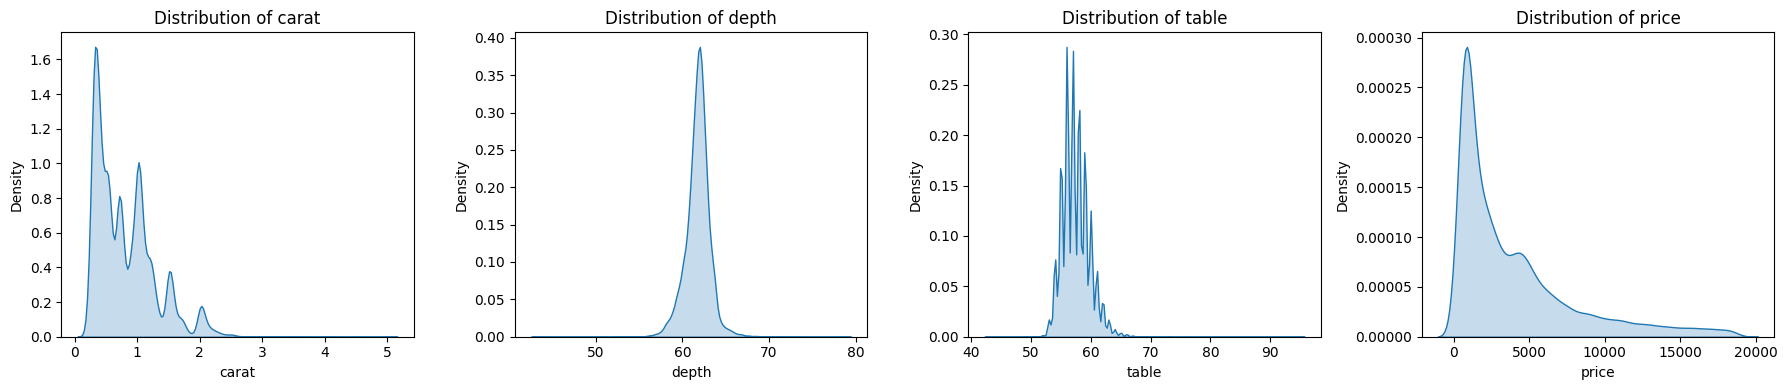

In [53]:
# Distribution of numerical features
num_cols = df.select_dtypes(include='number').columns
plt.figure(figsize=(18,4))
for i, col in enumerate(num_cols[:4]):
    plt.subplot(1,4,i+1)
    sns.kdeplot(df[col], fill=True)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

INTERPRETATION:

1. Carat
- Strong right-skewed (positively skewed) distribution
- Most diamonds are small, clustered below ~1 carat
- Very few large diamonds (>2 carats)

2. Depth : Very narrow, bell-shaped distribution around ~60

3. Table
- concentrated in a narrow range, roughly between 55–60
- Slight skew but mostly stable

4. Price
- Strong right-skewed distribution
- Most diamonds are priced lower
- A long tail shows some very expensive diamonds

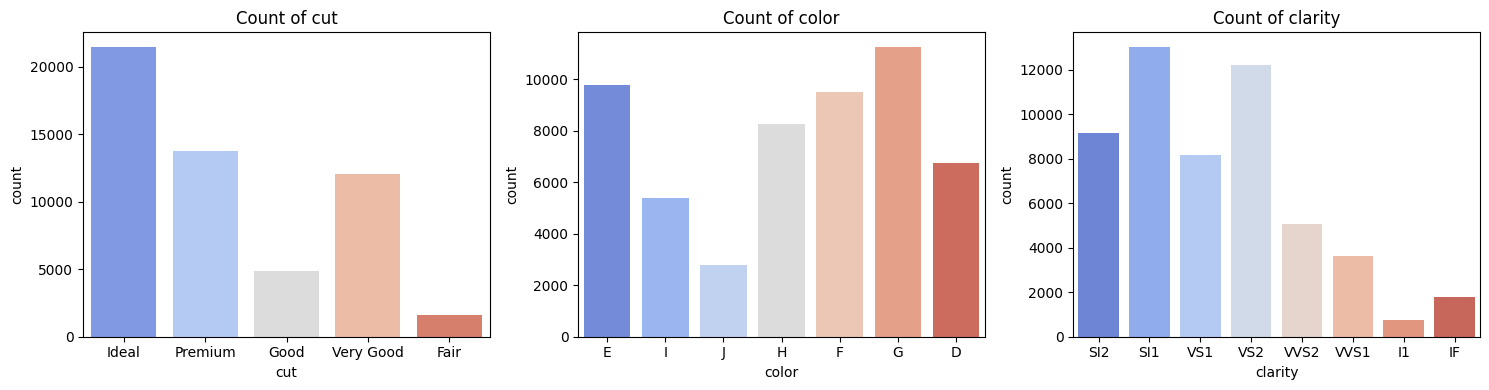

In [54]:
# Categorical countplots
cat_cols = ['cut', 'color', 'clarity']
plt.figure(figsize=(15,4))
for i, col in enumerate(cat_cols):
    plt.subplot(1,3,i+1)
    sns.countplot(data=df, x=col, hue=col, palette='coolwarm')
    plt.title(f"Count of {col}")
plt.tight_layout()
plt.show()

INTERPRETATIONS:

1. Cut Distribution
- Most frequent cut: Ideal → highest quality of cut, most common in market
- Followed by Premium and Very Good
- Good is much less frequent
- Fair is extremely rare

2. Color Distribution (Color scale: D = best (colorless) → J = worst (yellowish))

Most diamonds fall in G, F, H → near colorless range

- E also has a high count
- D (best quality) is fewer than mid-range colors
- I and J (lower quality) are present but less common than mid-range

3. Clarity Distribution (From best to worst: IF → VVS → VS → SI → I)

- SI1 and SI2 are most common
- Followed by VS2 and VS1
- VVS clarity exists but less frequent
- IF (best clarity) is very rare
- I1 (worst clarity) is also rare

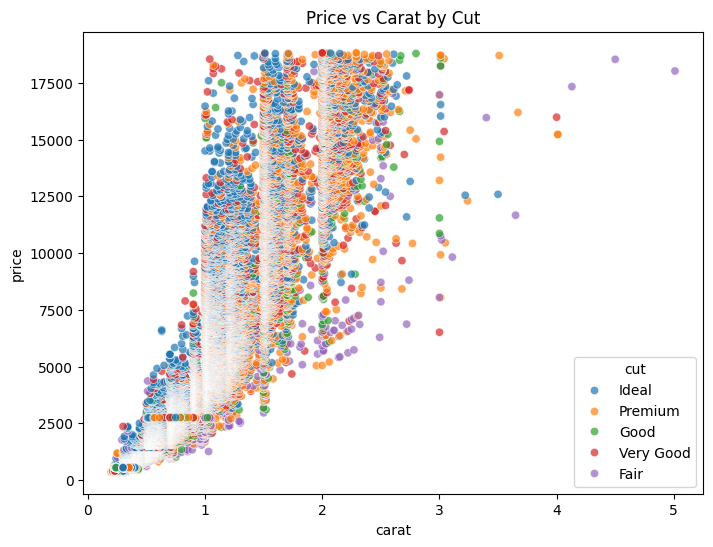

In [55]:
# Price vs Carat by Cut
plt.figure(figsize=(8,6))
sns.scatterplot(x='carat', y='price', hue='cut', data=df, alpha=0.7)
plt.title("Price vs Carat by Cut")
plt.show()

INTERPRETATIONS:

- As carat increases, price increases sharply
- Cut Influences Price (but less than carat). For the same carat, diamonds with better cuts (Ideal, Premium, Very Good) generally tend to cluster at higher prices than lower cuts (Good, Fair)
- Many expensive diamonds are Ideal or Premium
- Fair cut diamonds are mostly in the lower price range, even at similar carats

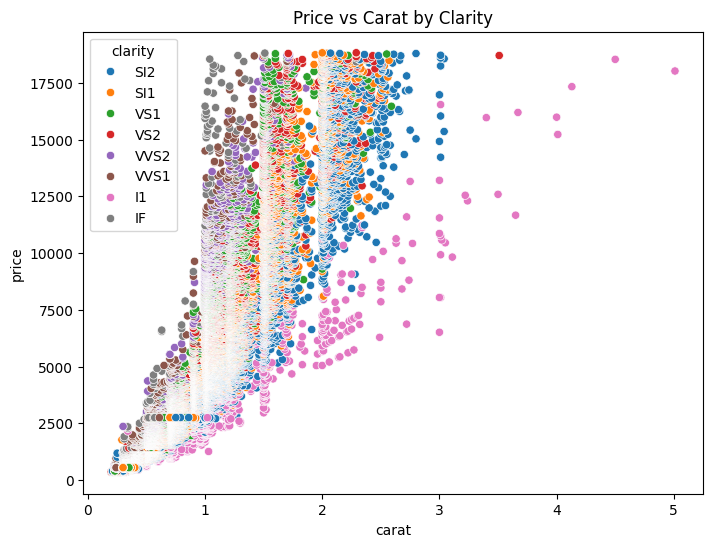

In [56]:
# Price vs Carat by Clarity
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='carat', y='price', hue='clarity')
plt.title("Price vs Carat by Clarity")
plt.show()

INTERPRETATION:

- Strong positive relationship: price increases sharply as carat increases.
- Clarity matters, but less than carat
- Higher clarity grades (IF, VVS1, VVS2) generally sit toward higher price ranges at the same carat
- Mid clarity (VS1, VS2, SI1, SI2) cover most of the distribution
- I1 clarity diamonds tend to be cheaper even at similar carats

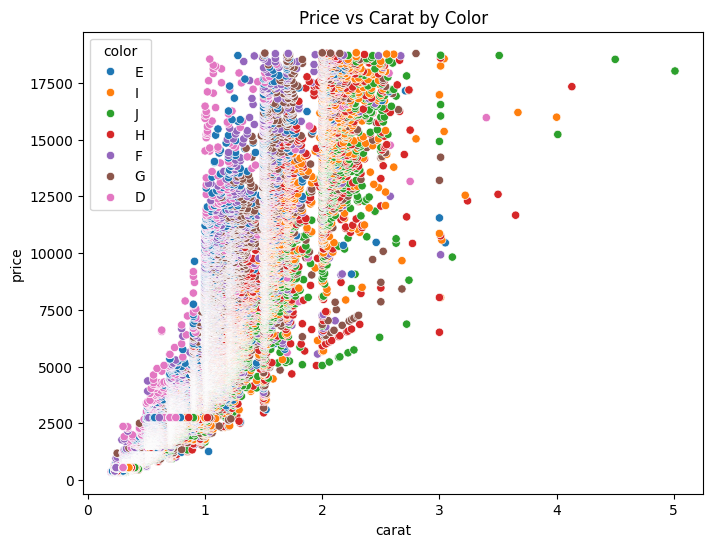

In [57]:
# Price vs Carat by Color

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='carat', y='price', hue='color')
plt.title("Price vs Carat by Color")
plt.show()

INTERPRETATION:

- carat drives price most strongly
- Color influences price, but the impact is moderate with overlap
- Higher quality colors (D, E, F) generally appear more in the higher price region
- Near-colorless (G, H) dominate the mass market → widely spread across prices
- Lower quality (I, J) tend to appear more in lower price ranges for similar carats

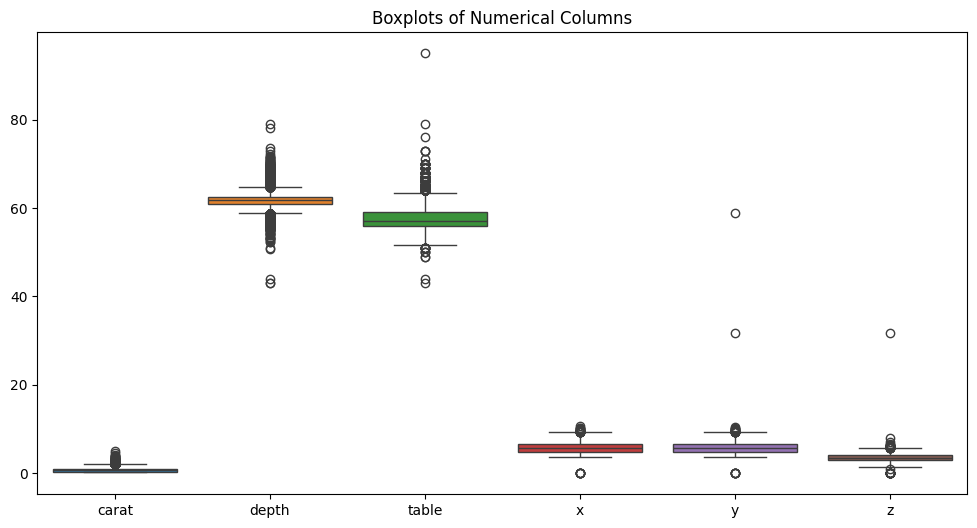

In [58]:
# Boxplots to detect outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['carat','depth','table','x','y','z']])
plt.title("Boxplots of Numerical Columns")
plt.show()

In [59]:
# Remove physically impossible values (x, y, z = 0)
df = df[(df['x'] > 0) & (df['y'] > 0) & (df['z'] > 0)]

In [60]:
# Apply IQR method for x, y, z, depth, table features

cols_iqr = ['x', 'y', 'z', 'depth', 'table']

for col in cols_iqr:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df = df[(df[col] >= lower) & (df[col] <= upper)]

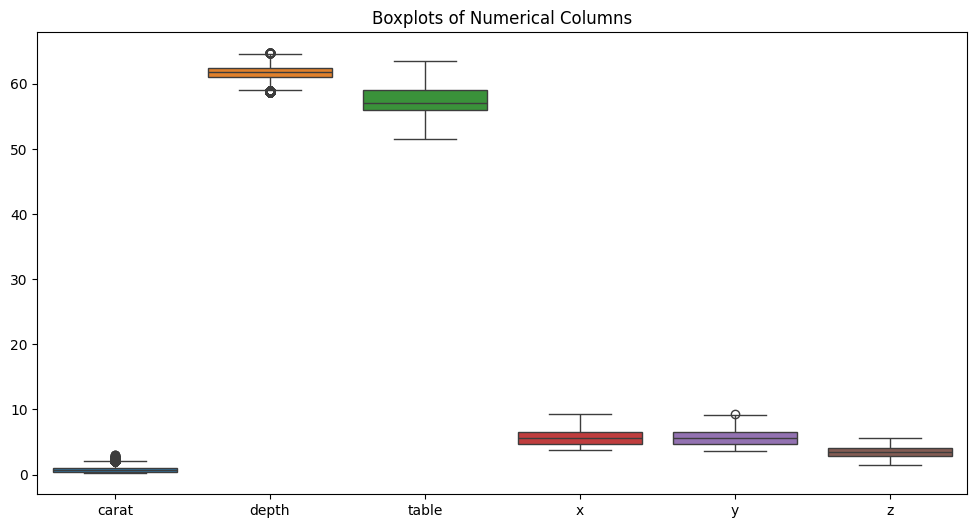

In [61]:
# Boxplot after capping outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['carat','depth','table','x','y','z']])
plt.title("Boxplots of Numerical Columns")
plt.show()

In [62]:
# Create a new column for log-transformed price and log-transformed carat
df['price_log'] = np.log(df['price'])
df['carat_log'] = np.log(df['carat'])

diamond_data['price'] : This selects the `price` column from your DataFrame `diamond_data`.

This column contains the raw diamond prices, e.g., 500, 1500, 12000, etc.

np.log1p(x) :  is a NumPy function that computes:

- log(1 + x)

This is the natural logarithm (base e) of 1 + x.

It is slightly different from just np.log(x) because it is more accurate for very small values of x, including 0.

Example:

| x   | np.log(x) | np.log1p(x) |
| --- | --------- | ----------- |
| 0   | -inf      | 0           |
| 1   | 0         | 0.693       |
| 100 | 4.605     | 4.615       |

Why log transformation?
- Price data is often skewed — there are many low-priced diamonds and a few extremely high-priced ones.
- Log-transforming reduces skewness and brings the distribution closer to normal, which is often better for machine learning models.
- It also makes relationships more linear with other features.

diamond_data['price_log'] = ...
- This creates a new column in your DataFrame called price_log and stores the log-transformed values there.
- After this, you can use price_log instead of price for modeling or visualization.

Summary:

- We are transforming price to log(1 + price) to stabilize variance, reduce skew, and avoid issues with 0 values.
- price_log is now the log-transformed price column ready for further analysis.

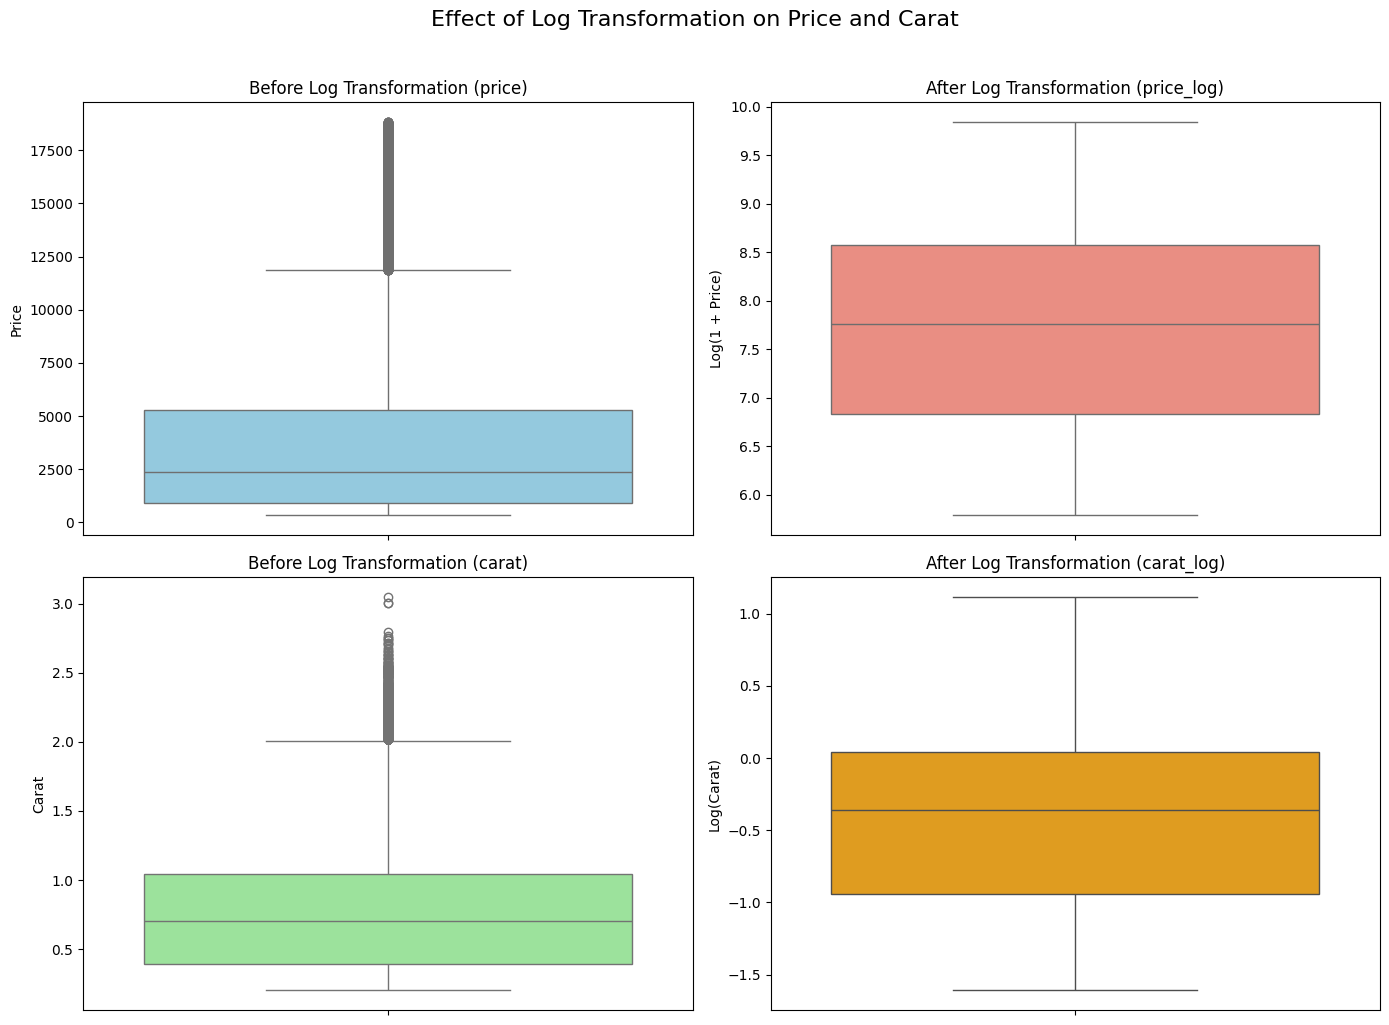

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# -------- PRICE --------
# Before log transformation
sns.boxplot(y=df['price'], ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title("Before Log Transformation (price)", fontsize=12)
axes[0, 0].set_ylabel("Price")

# After log transformation
sns.boxplot(y=df['price_log'], ax=axes[0, 1], color='salmon')
axes[0, 1].set_title("After Log Transformation (price_log)", fontsize=12)
axes[0, 1].set_ylabel("Log(1 + Price)")

# -------- CARAT --------
# Before log transformation
sns.boxplot(y=df['carat'], ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title("Before Log Transformation (carat)", fontsize=12)
axes[1, 0].set_ylabel("Carat")

# After log transformation
sns.boxplot(y=df['carat_log'], ax=axes[1, 1], color='orange')
axes[1, 1].set_title("After Log Transformation (carat_log)", fontsize=12)
axes[1, 1].set_ylabel("Log(Carat)")

plt.suptitle("Effect of Log Transformation on Price and Carat", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


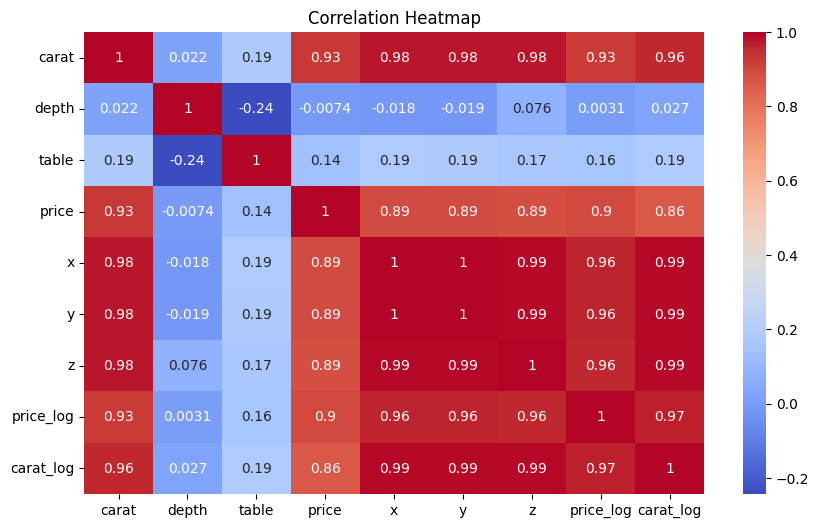

In [64]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

INTERPRETATIONS:

1. Price has very high positive correlation with:
- carat → 0.91
- x (length) → 0.87
- y (width) → 0.87
- z (depth in mm) → 0.86
- price_log → 0.90 (as expected)

2. Extremely High Multicollinearity:
- carat, x, y, z are ~0.98–0.99 correlated with each other

3. Weak or Negligible Relationships
- depth → almost no correlation with price (-0.01)
- table → weak correlation (~0.14)

In [65]:
!pip install statsmodels

In [66]:
# Checking VIF (Multicollinearity Test)

from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['carat_log','x','y','z','depth','table']]

vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif)

     Feature           VIF
0  carat_log    120.174213
1          x  13281.216966
2          y  12292.411481
3          z   7881.184020
4      depth   3465.357207
5      table    809.298787


- All variables have VIF >> 10
- This indicates extreme, severe multicollinearity

In [67]:
# Final Feature Dataset
df_model = df[['price_log','carat_log','cut','color','clarity']]

In [68]:
# Define features and target
X = df_model.drop('price_log', axis=1)
y = df_model['price_log']

In [69]:
# preprocessing
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

In [70]:
# Finding Best Random State

best_random_state = None
best_r2 = -np.inf

for rs in range(0, 51):
    X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(
        X, y, test_size=0.2, random_state=rs
    )

    temp_pipe = Pipeline([
        ('prep', preprocess),
        ('model', RandomForestRegressor(
            n_estimators=20,
            random_state=42,
            n_jobs=-1
        ))
    ])

    temp_pipe.fit(X_train_rs, y_train_rs)
    pred = temp_pipe.predict(X_test_rs)
    r2 = r2_score(y_test_rs, pred)

    if r2 > best_r2:
        best_r2 = r2
        best_random_state = rs

print("Best Random State:", best_random_state)
print("Best R²:", best_r2)

Best Random State: 14
Best R²: 0.9896604509512283


In [71]:
# Split using Best Random State
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=best_random_state)

In [72]:
# Defining Models and Parameter Grids

models = {
    "LinearRegression": (
        Pipeline([
            ('prep', preprocess),
            ('scaler', StandardScaler(with_mean=False)),
            ('model', LinearRegression())
        ]),
        {}
    ),

    "Ridge": (
        Pipeline([
            ('prep', preprocess),
            ('scaler', StandardScaler(with_mean=False)),
            ('model', Ridge())
        ]),
        {'model__alpha':[0.1, 1, 10]}
    ),

    "Lasso": (
        Pipeline([
            ('prep', preprocess),
            ('scaler', StandardScaler(with_mean=False)),
            ('model', Lasso(max_iter=5000))
        ]),
        {'model__alpha':[0.001, 0.01, 0.1, 1]}
    ),

    "DecisionTree": (
        Pipeline([
            ('prep', preprocess),
            ('model', DecisionTreeRegressor())
        ]),
        {'model__max_depth':[5, 10, 20, None]}
    ),

    "RandomForest": (
        Pipeline([
            ('prep', preprocess),
            ('model', RandomForestRegressor())
        ]),
        {'model__n_estimators':[200, 500], 'model__max_depth':[None, 20]}
    ),

    "GradientBoosting": (
        Pipeline([
            ('prep', preprocess),
            ('model', GradientBoostingRegressor())
        ]),
        {'model__n_estimators':[100, 200], 'model__learning_rate':[0.05, 0.1]}
    ),

    "AdaBoost": (
        Pipeline([
            ('prep', preprocess),
            ('model', AdaBoostRegressor())
        ]),
        {'model__n_estimators':[50, 100]}
    ),

    "SVR": (
        Pipeline([
            ('prep', preprocess),
            ('scaler', StandardScaler(with_mean=False)),
            ('model', SVR())
        ]),
        {'model__C':[1, 10], 'model__gamma':['scale']}
    ),

    "XGBoost": (
        Pipeline([
            ('prep', preprocess),
            ('model', XGBRegressor(objective='reg:squarederror'))
        ]),
        {'model__n_estimators':[300, 500], 'model__learning_rate':[0.05, 0.1]}
    )
}

In [73]:
import numpy as np
# Initialize storage for results

results = []
best_model = None
best_model_name = None
best_mae = np.inf

for name, (pipe, grid) in models.items():
    print(f"\n Searching best params for: {name}")

    # Use RandomizedSearch if grid is large
    search = (
        RandomizedSearchCV(
            pipe,
            grid,
            n_iter=15,
            scoring='neg_mean_absolute_error',
            cv=3,
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        if len(grid) > 3 else
        GridSearchCV(
            pipe,
            grid,
            scoring='neg_mean_absolute_error',
            cv=3,
            n_jobs=-1,
            verbose=0
        )
    )

    search.fit(X_train, y_train)

    pred = search.predict(X_test)

    test_r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))

    results.append([name, test_r2, mae, rmse])

    if mae < best_mae:
        best_mae = mae
        best_model = search.best_estimator_
        best_model_name = name

results_df = pd.DataFrame(
    results,
    columns=["Model", "Test R2", "MAE", "RMSE"]
)

print("\n Best Model:", best_model_name)
print(results_df.sort_values(by="Test R2", ascending=False))


 Searching best params for: LinearRegression

 Searching best params for: Ridge

 Searching best params for: Lasso

 Searching best params for: DecisionTree

 Searching best params for: RandomForest

 Searching best params for: GradientBoosting

 Searching best params for: AdaBoost

 Searching best params for: SVR

 Searching best params for: XGBoost

 Best Model: XGBoost
              Model   Test R2       MAE      RMSE
8           XGBoost  0.991063  0.074531  0.097288
4      RandomForest  0.989832  0.078934  0.103773
5  GradientBoosting  0.989617  0.081725  0.104864
3      DecisionTree  0.988534  0.082571  0.110197
7               SVR  0.988328  0.087867  0.111181
1             Ridge  0.983861  0.102355  0.130737
0  LinearRegression  0.983861  0.102355  0.130737
2             Lasso  0.983825  0.102476  0.130882
6          AdaBoost  0.948044  0.188156  0.234575


In [74]:
# Select the best model based on MAE

print("\nBest Model Based on MAE:")
print(best_model_name)

best_model_r2 = results_df.loc[results_df['Model'] == best_model_name, 'Test R2'].values[0]
print(f"Best Test R2: {best_model_r2:.4f}")


Best Model Based on MAE:
XGBoost
Best Test R2: 0.9911


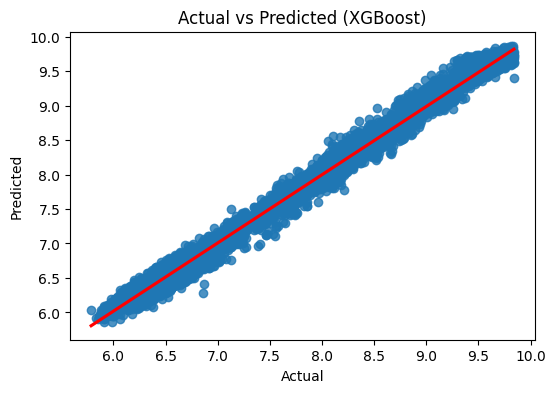

In [75]:
# Predict with the best Model
pred = best_model.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(6,4))
sns.regplot(x=y_test, y=pred, ci=None, line_kws={'color':'red'})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted ({best_model_name})")
plt.show()

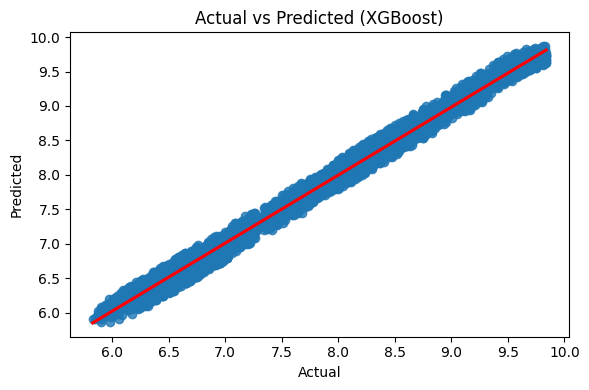

In [76]:
# Predict
pred = best_model.predict(X_test)

# Compute residuals
residuals = y_test - pred

# IQR-based outlier removal (for visualization only)
Q1 = np.percentile(residuals, 25)
Q3 = np.percentile(residuals, 75)
IQR = Q3 - Q1

mask = (residuals >= Q1 - 1.5 * IQR) & (residuals <= Q3 + 1.5 * IQR)

# Filter values
y_test_filt = y_test[mask]
pred_filt = pred[mask]

# Plot Actual vs Predicted
plt.figure(figsize=(6, 4))
sns.regplot(x=y_test_filt, y=pred_filt, ci=None, line_kws={'color': 'red'})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted ({best_model_name})")
plt.tight_layout()
plt.show()

In [77]:
# Predict log price
y_pred_log = best_model.predict(X_test)

# Convert back to actual USD price
y_pred = np.exp(y_pred_log)

# Convert actual log price back to USD
y_test_actual = np.exp(y_test)


In [78]:
# Build comparison dataframe

# Inverse transform
actual_price = np.exp(y_test)
predicted_price = np.exp(pred)

# Compare
df_compare = pd.DataFrame({
    "Actual_Price_USD": actual_price.values,
    "Predicted_Price_USD": predicted_price
})

print("\nSample predictions:")
print(df_compare.head(10))


Sample predictions:
   Actual_Price_USD  Predicted_Price_USD
0            2854.0          2895.875000
1            1216.0          1362.864868
2             776.0           621.889343
3            3994.0          3874.196289
4            4452.0          4371.019043
5           13437.0         16079.551758
6            1815.0          1745.904175
7             671.0           747.788574
8             712.0           875.853577
9            1407.0          1558.744385


In [79]:
# Save the best Model

joblib.dump(best_model, "best_regression_model.pkl")
print(f"\n Saved best model: {best_model_name} → best_regression_model.pkl")


 Saved best model: XGBoost → best_regression_model.pkl


In [80]:
# Load the Model

best_model = joblib.load("best_regression_model.pkl")

In [81]:
# Create unseen sample
new_data = pd.DataFrame([{
    "carat_log": 0.9,
    "cut": "Ideal",
    "color": "E",
    "clarity": "VS1",
}])

In [82]:
# Predict (log price)
price_log_pred = best_model.predict(new_data)

In [83]:
# Convert back to actual price
price_pred = np.expm1(price_log_pred)

print("Predicted Price:", price_pred[0])

Predicted Price: 19223.855


In [84]:
price_pred = np.exp(price_log_pred)
print("Predicted Diamond Price:", price_pred[0])


Predicted Diamond Price: 19224.855


The model is predicting that the unseen diamond would cost approximately
USD 19,225.

## Final Conclusion:

The model predicts diamond prices based on carat, cut, color, and clarity. Diamond price increases with higher carat weight and better quality grades. Among all features, carat has the strongest impact, while cut, color, and clarity further influence the final price.